In [1]:
import sys
sys.path.append("..")
from dataset.dataloader import MyOcrDataloader, MyCustomOcrDataloader, OCRDataAugmentor
import pandas as pd
import math
import random
import torch
import yaml
import wandb
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import gc
from utils.utils import *
from utils.charactertokenizer import CharacterTokenizer
from jiwer import wer, cer
from models.models import TrOCRMyDecoder
from tqdm.auto import tqdm

/home/ubuntu/datagen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config {'SCENARIO': 1, 'USE_WANDB': False, 'TRAIN_TASK': 'SYNTHETIC', 'HANDWRITTEN_TRAIN_PATH': '/home/ubuntu/data/handwritten_labels/gabby_handwritten_train.csv', 'HANDWRITTEN_VAL_PATH': '/home/ubuntu/data/handwritten_labels/gabby_handwritten_test.csv', 'HANDWRITTEN_IMG_ROOT': '/home/ubuntu/data/Amharic_Data/train', 'HANDWRITTEN_IMG_ROOT_TEST': '/home/ubuntu/data/Amharic_Data/test', 'TYPED_TRAIN_PATH': '/home/ubuntu/data/typed_labels/gabby_typed_train.csv', 'TYPED_VAL_PATH': '/home/ubuntu/data/typed_labels/gabby_typed_test.csv', 'TYPED_IMG_ROOT': '/home/ubuntu/data/Amharic_Data/train', 'TYPED_IMG_ROOT_TEST': '/home/ubuntu/data/Amharic_Data/test', 'SYNTHETIC_TRAIN_PATH': '/home/ubuntu/data/synthetic_data/labels/gabby_synthetic_train.csv', 'SYNTHETIC_VAL_PATH': '/home/ubuntu/data/synthetic_data/labels/gabby_synthetic_test.csv', 'SYNTHETIC_IMG_ROOT': '/home/ubuntu/data/Amharic_Data/train', 'SYNTHETIC_IMG_ROOT_TEST': '/home/ubuntu/data/Amharic_Data/test', 'HDD_TRAIN_PATH': '/home/ubuntu/d

In [2]:
config_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), "config/main.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
task  = config["TRAIN_TASK"]
os.environ["TOKENIZERS_PARALLELISM"] = "false"

TRAIN_PATH =config[task+"_"+"TRAIN_PATH"]
VAL_PATH =config[task+"_"+"VAL_PATH"]
IMG_ROOT = config[task+"_"+"IMG_ROOT"]

MODEL_ID = config["MODEL_ID"]

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = resize_and_patch_image
# model =VisionEncoderDecoderModel.from_pretrained(MODEL_ID).to(device)
# model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size

In [3]:
## sanity check for data loader
os.chdir("../dataset")
augmentor = OCRDataAugmentor()
tokenizer = CharacterTokenizer.from_pretrained('/home/ubuntu/HandWritten_Amharic_English_OCR/Amharic_Char_Tokenizer2')
# tokenizer = PreTrainedTokenizerFast.from_pretrained("/home/ubuntu/data/synthetic_data/amharic_tokenizer_hf")

# tokenizer = AutoTokenizer.from_pretrained("rasyosef/bert-amharic-tokenizer")

if tokenizer.bos_token_id== None:
    print("setting tokenizer")
    special_tokens_dict = {
    "bos_token": "<sos>",
    "eos_token": "<eos>"
    }
    tokenizer.add_special_tokens(special_tokens_dict)

train_data = MyCustomOcrDataloader(TRAIN_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT, transform=augmentor)
IMG_ROOT = config[task+"_IMG_ROOT"+"_TEST"]
val_data = MyCustomOcrDataloader(VAL_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT)
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )



In [4]:

train_loader    = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn,
)

print("No. of Train Images   : ", train_data.__len__())
print("Batch Size           : ", config["BATCH_SIZE"])
print("Train Batches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())

No. of Train Images   :  10000
Batch Size           :  128
Train Batches        :  79
Val Batches          :  79


In [5]:

train_loader    = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn,
)

print("No. of Train Images   : ", train_data.__len__())
print("Batch Size           : ", config["BATCH_SIZE"])
print("Train Batches        : ", train_loader.__len__())
print("No. of Val Images   : ", val_data.__len__())

print("Val Batches          : ", val_loader.__len__())

No. of Train Images   :  10000
Batch Size           :  128
Train Batches        :  79
No. of Val Images   :  10000
Val Batches          :  79


In [6]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0
    running_cer = 0.0
    running_wer = 0.0
    running_char_f1 = 0.0
    running_word_f1 = 0.0


    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        dist, cer, wer, charf1, word_f1 = calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=True)
        running_distance += dist
        running_cer += cer
        running_wer += wer
        running_char_f1 += charf1
        running_word_f1 += word_f1


        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1))),
            running_cer = "{:.04f}".format(float(running_cer / (i + 1))),
            running_wer = "{:.04f}".format(float(running_wer / (i + 1))),
            running_char_f1 = "{:.04f}".format(float(running_char_f1 / (i + 1))),
            running_word_f1 = "{:.04f}".format(float(running_word_f1 / (i + 1)))

        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5
    running_cer /= 5
    running_wer /= 5
    running_char_f1 /= 5
    running_word_f1 /= 5

    return running_distance, running_cer, running_wer, running_char_f1, running_word_f1

def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0
    running_cer = 0.0
    running_wer = 0.0
    running_char_f1 = 0.0
    running_word_f1 =0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        dist, cer, wer, charf1, word_f1 = calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=False)
        running_distance += dist
        running_cer += cer
        running_wer += wer
        running_char_f1 += charf1
        running_word_f1 += word_f1


        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1))),
            running_cer = "{:.04f}".format(float(running_cer / (i + 1))),
            running_wer = "{:.04f}".format(float(running_wer / (i + 1))),
            running_char_f1 = "{:.04f}".format(float(running_char_f1 / (i + 1))),
            running_word_f1 = "{:.04f}".format(float(running_word_f1 / (i + 1)))

        )
        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)
    running_cer /= len(dataloader)
    running_wer /= len(dataloader)
    running_char_f1 /= len(dataloader)
    running_word_f1 /= len(dataloader)


    return running_distance, running_cer, running_wer, running_char_f1, running_word_f1

In [7]:

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([128, 1, 1, 128, 1536])
x_len shape:		torch.Size([128])

y_shifted_pad shape:	torch.Size([128, 117])
y_golden_pad shape:	torch.Size([128, 117])
y_len shape:		torch.Size([128])



In [25]:


# %%
''' Please refer to the config file and top sections to fill in the following '''

model = TrOCRMyDecoder(
input_dim                   = None,
dec_num_layers              = config["dec_num_layers"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = tokenizer.vocab_size,
eos_token                   = tokenizer.eos_token_id,
sos_token                   = tokenizer.bos_token_id,
pad_token                   = tokenizer.pad_token_id,

enc_dropout                 = config["enc_dropout"],
dec_dropout                 = config["enc_dropout"],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 512 , # Max sequence length for transcripts. Check data verification.
).to(device)



e                   = 0
best_loss           = 20


best_loss_model_path  = "/home/ubuntu/HandWritten_Amharic_English_OCR/dataset/checkpoints-basic-cnn-trocr/TYPEDcheckpoint-best-distance-model.pth"

checkpoint = torch.load(best_loss_model_path)

model.load_state_dict(checkpoint['model_state_dict'])
def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)



/home/ubuntu/datagen/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/datagen/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##########
Model Parameters:
 15.758103
##########


In [26]:
data = pd.read_csv('/home/ubuntu/data/typed_labels/gabby_typed_test.csv')

torch.Size([1, 1, 1, 128, 1536])


አመ                                                                                                 -> ነገር አለመኖሩ  ነው።  ባለሁበት  ሐላፊነትና  እንደ  አንድ  ምእመን  ሆኜ ሳየው  መዝሙር  አጠቃላይ  ሒደቱ  ሥርዓቱ  መሥመር  እየሳተ  ነው።  ከነዚህም


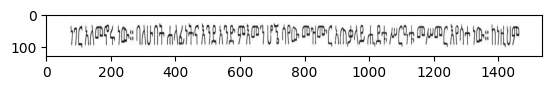

In [27]:
import random 

id = random.randint(0, len(data))
row = data.iloc[id]
# image = Image.open(os.path.join(IMG_ROOT, row["images"])).convert("L")
image = Image.open(os.path.join(IMG_ROOT, row["image_filename"]))
inp = processor(image, return_tensors="pt").pixel_values.to("cuda").unsqueeze(0)
print(inp.shape)
with torch.inference_mode():
    greedy_predictions = model.recognize(inp, None)
pred_text  =  tokenizer.decode(greedy_predictions[0], skip_special_tokens = True)
print(pred_text, "->", row["line_text"] )
plt.imshow(inp[0][0].permute((1,2,0)).to('cpu'), cmap='gray')
# image, 

In [28]:

levenshtein_distance, cer, wer, charf1, wordf1 = validate_fast(model, val_loader)

Val:   0%|          | 0/79 [00:00<?, ?it/s]


Ground Truth :  ያካሄዱት አካላት ለመስተዳደሩ በጹኁፍ ያላሳወቁ መሆኑ ከአቶ ማርቆስ ብዙነህ የሰላማዊ ሠልፍና ስብሰባ ማሳወቂያ ኦፍሲር በገለጹት መሠረት ለመረዳ ተችሎሃል::
Prediction   :  መ                                                                                                


Val:   1%|▏         | 1/79 [00:23<30:50, 23.73s/it, running_cer=0.9899, running_char_f1=0.1922, running_distance=84.2188, running_wer=0.9996, running_word_f1=0.0000]


Ground Truth :  እንዲህ ማድረግ ትችዪ ይሆናል::
Prediction   :  መ                                                                                                


Val:   3%|▎         | 2/79 [00:34<20:53, 16.28s/it, running_cer=0.9894, running_char_f1=0.1917, running_distance=84.2148, running_wer=0.9996, running_word_f1=0.0000]


Ground Truth :  እቴጌይት መግደርደር እኮ ኩራት ከሚገለጥበት አንዱ መንገድ ነው ትንሿን ነገር ቢግ ዲል ማድረግ ግን የተጨናቂነት ወይም የነጭናጫነት ወይም ቅድሚያ የሚሰጠውን
Prediction   :  መ                                                                                                


Val:   4%|▍         | 3/79 [00:43<16:19, 12.89s/it, running_cer=0.9893, running_char_f1=0.1926, running_distance=84.1823, running_wer=0.9997, running_word_f1=0.0000]


Ground Truth :  ፈርዖንም የዮሴፍን ስም ጸፍናት ፐዕናህ ብሎ ጠራው የሄልዮቱ ከተማ ካህን የጶጥፌራ ልጅ የምትሆን አስናትን አጋባው ዮሴፍም በግብፅ ምድር ሁሉ ወጣ::
Prediction   :  መ                                                                                                


Val:   5%|▌         | 4/79 [00:54<15:10, 12.15s/it, running_cer=0.9897, running_char_f1=0.1927, running_distance=84.1816, running_wer=0.9998, running_word_f1=0.0000]


Ground Truth :  ፲፱፻፶፪ ዓም በሞሮኮ የተከሰተ የመሬት እንቅጥቅጥ አጋዲር የተባለችውን ከተማ አወደመ::
Prediction   :  መ                                                                                                


In [ ]:
levenshtein_distance, cers, wers, charf1, wordf1 = validate_full(model, val_loader)

In [18]:

import matplotlib.font_manager as fm
font_path = "/data/synthetic_data/static/NotoSansEthiopic-Black.ttf"
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

FileNotFoundError: [Errno 2] No such file or directory: '/data/synthetic_data/static/NotoSansEthiopic-Black.ttf'

In [5]:

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0
    running_cer = 0.0
    running_wer = 0.0

    # Create a figure for displaying results
    plt.figure(figsize=(100, 4))
    
    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets_golden = targets_golden.to(device)


        # Display images and predictions for the first batch
        if i == 0:
            # Convert tensor to numpy and denormalize if needed
            images = inputs.cpu().numpy()
            if images.shape[1] == 1:  # Grayscale
                images = np.squeeze(images, axis=1)
            else:  # RGB
                images = np.transpose(images, (0, 2, 3, 1))
            
            # Display up to 4 examples from the first batch
            num_examples = min(4, inputs.size(0))
            for j in range(num_examples):
                # plt.subplot(2, 2, j+1)
                
                # Display image
                if images[j].shape[0] == 3:  # RGB
                    
                    plt.imshow(np.transpose(images[j], (1, 2, 0)))
                else:  # Grayscale
                    plt.imshow(images[j], cmap='gray')
                
                # Get prediction and ground truth text
                # pred_text = tokenizer.decode(greedy_predictions[j])
                # true_text = tokenizer.decode(targets_golden[j].cpu().numpy())
                
                # # Format the title
                # title = f"Pred: {pred_text}\nTrue: {true_text}"
                # if pred_text == true_text:
                #     plt.title(title, color='green')
                # else:
                #     plt.title(title, color='red')
                
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # Calculate metrics
        dist, cer, wer = calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=False)
        running_distance += dist
        running_cer += cer
        running_wer += wer



        # Update progress bar
        batch_bar.set_postfix(
            running_distance="{:.04f}".format(float(running_distance / (i + 1))),
            running_cer="{:.04f}".format(float(running_cer / (i + 1))),
            running_wer="{:.04f}".format(float(running_wer / (i + 1)))
        )
        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i == 4:  # validating only upon first five batches
            break

    batch_bar.close()
    running_distance /= 5
    running_cer /= 5
    running_wer /= 5

    return running_distance, running_cer, running_wer

def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance


#

In [ ]:
levenshtein_distance = validate_fast(model, val_loader)
